# Taxi Compass
by Alejandro Seif

# **Day 1: Data Collection**

## LTA Taxi Availability data API

* Import statement

In [11]:
import requests
import pandas as pd
import time
from datetime import datetime
import numpy as np

### Sequential Taxi Data API Interaction

This Information updates every 50-60 seconds, so this service can be called at most 1x per minute

In [ ]:
gov = 'https://api.data.gov.sg/v1'
taxi_url = '/transport/taxi-availability'

url = gov + taxi_url
response = requests.get(url).json()

response

In [ ]:
timestamp_str = response['features'][0]['properties']['timestamp']
timestamp = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S+08:00')
print(timestamp)

In [ ]:
taxi_coordinates = response['features'][0]['geometry']['coordinates']
taxi_coordinates_df= pd.DataFrame.from_dict(taxi_coordinates)
taxi_coordinates_df= taxi_coordinates_df.rename(columns = {0:'lon',1:'lat'})
taxi_coordinates_df['timestamp']=timestamp
taxi_coordinates_df.astype({'lat':'float32','lon':'float32'})
taxi_coordinates_df

Now we are going to be setting up a function to retrieve and append so that it can be called

In [ ]:
def taxi_coordinates_append(df):
    '''
    Pass an existing dataframe to append more data
    '''
    gov = 'https://api.data.gov.sg/v1'
    taxi_url = '/transport/taxi-availability'

    url = gov + taxi_url
    response = requests.get(url).json()
    
    timestamp_str = response['features'][0]['properties']['timestamp']
    timestamp = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S+08:00')
    
    taxi_coordinates = response['features'][0]['geometry']['coordinates']
    temp_taxi_coordinates_df= pd.DataFrame.from_dict(taxi_coordinates)
    temp_taxi_coordinates_df= temp_taxi_coordinates_df.rename(columns = {0:'lon',1:'lat'})
    temp_taxi_coordinates_df['timestamp']=timestamp
    temp_taxi_coordinates_df.astype({'lat':'float32','lon':'float32'})
    return pd.concat([df,temp_taxi_coordinates_df])
    

In [ ]:
taxi_coordinates_append(taxi_coordinates_df)

### Weather data API Interaction

This service updates once every 5 minutes

In [ ]:
gov = 'https://api.data.gov.sg/v1'
weather_api = '/environment/rainfall'

url = gov+weather_api
response = requests.get(url).json()

response

In [ ]:
response['items'][0]['timestamp']

In [ ]:
response['metadata']['stations'][0]

In [ ]:
response['items'][0]['readings'][0]

In [ ]:
{'id':response['metadata']['stations'][0]['id'], 
 'lat':response['metadata']['stations'][0]['location']['latitude'],
'lon':response['metadata']['stations'][0]['location']['longitude'],
'value':response['items'][0]['readings'][0]['value'],
'timestamp':response['items'][0]['timestamp']}

In [ ]:
weather_list = []
for index,value in enumerate(response['items'][0]['readings']):
    weather_list.append({'id':response['metadata']['stations'][index]['id'], 
 'lat':response['metadata']['stations'][index]['location']['latitude'],
'lon':response['metadata']['stations'][index]['location']['longitude'],
'value':response['items'][0]['readings'][index]['value'],
'timestamp':response['items'][0]['timestamp']})

In [ ]:
pd.DataFrame(weather_list)

In [ ]:
def parse_rainfall_data():
    '''
    This function calls the rainfall API
    and parses it into a dataframe.
    Available columns are id, lat, lon, value and timestamp
    
    value represents rainfall, where 0 is no rain.
    '''
    gov = 'https://api.data.gov.sg/v1'
    weather_api = '/environment/rainfall'

    url = gov+weather_api
    response = requests.get(url).json()

    timestamp_str = response['items'][0]['timestamp']
    timestamp = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S+08:00')
    weather_list = []
    for index,value in enumerate(response['items'][0]['readings']):
        weather_list.append({'id':response['metadata']['stations'][index]['id'], 
     'lat':response['metadata']['stations'][index]['location']['latitude'],
    'lon':response['metadata']['stations'][index]['location']['longitude'],
    'value':response['items'][0]['readings'][index]['value'],
    'timestamp': timestamp})
        
    return pd.DataFrame(weather_list)

parse_rainfall_data()

## Ranked distance between lat lon points - pandas apply

Given 2 sets of (lat,lon) this function is to calculate the 
haversine distance between a point and a set of fixed points 
then find the nearby pairs, ranked by distance

In [ ]:
from math import radians, sin, cos, asin, sqrt

def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Compute distance between two pairs of coordinates (lon1, lat1, lon2, lat2)
    See - (https://en.wikipedia.org/wiki/Haversine_formula)
    Distance is measured in kilometers when r = 6371
    r = 6371  Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    Lats and Longs are converted to radians first then computed used haversine
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    radius = 6371
    return 2 * radius * asin(sqrt(a))

df = parse_rainfall_data()
df

In [ ]:
test_lat, test_lon = 1.41720, 103.74855

df['distance']=df.apply(lambda row: haversine_distance(row.lon, row.lat, test_lon, test_lat)
                        , axis=1)
df.sort_values(by='distance')

In [ ]:
def point_to_set_ranked_distance(test_lat, test_lon, df, cutoff=10):
    '''
    Provide a test latitude and longitude to compare with 
    a dataframe df, which has columns 'lat' and 'lon'
    '''
    df = df[['lat','lon']]
    df['distance']=df.apply(lambda row: haversine_distance(row.lon, row.lat, test_lon, test_lat)
                        , axis=1)
    return df.sort_values(by='distance').iloc[:cutoff]

In [ ]:
df = df.drop(columns=['distance'])
point_to_set_ranked_distance(1.3137, 103.99, df)

So far this is OK-fast for comparing 1 point with a set of fixed points (e.g. a taxi with all taxi-stands).
Doing this for all taxis (and all taxi stands) might be time consuming (1-2 minutes?)

## Day 3


### Taxi Stop Data

This data is avaiable as a GeoJSON in:
https://data.gov.sg/dataset/lta-taxi-stop?resource_id=113b362f-ffc7-4e06-adb1-1c06e8b8ae90



In [ ]:
import json

with open('../raw_data/lta-taxi-stop-geojson.geojson') as geofile:
    taxi_stands_json = json.load(geofile)

taxi_stands_json

I will now parse the contents so as to keep the Name and Coordinates of taxi stands

In [ ]:
taxi_stands_dict = []

for ts in taxi_stands_json['features']:
    taxi_stands_dict.append( {'ts_id':ts['properties']['Name'],'lat':ts['geometry']['coordinates'][1] ,
                                                'lon':ts['geometry']['coordinates'][0]})
ts_df = pd.DataFrame(taxi_stands_dict)
ts_df.head()

### Ranked distance between lat lon points - numpy broadcasting

Given 2 sets of (lat,lon) this function is to calculate the 
haversine distance between a point and a set of fixed points 
then find the nearby pairs, ranked by distance

In [ ]:
def find_nearest_taxi_stand(taxi_lat=1.281261,taxi_lon=103.846358):
    '''
    Given all the static positions of the nearby taxi stands
    we can get the distance with all of them, and return the nearest 10 taxi stands.
    
    We can assume that a taxi is IN the taxi stand when the distance is < 100 m = 0.1 km
    
    Python wise we'll be using broadcasting method, so we do the difference of all taxi stands (ts)
    with a given taxi_lat and taxi_lon in one shot, not in a for loop.
    '''

    taxi_lat_rad = np.deg2rad(taxi_lat)
    taxi_lon_rad = np.deg2rad(taxi_lon)

    ts_lat = np.array(ts_df['lat'].tolist())
    ts_lat_rad = np.deg2rad(ts_lat)

    ts_lon = np.array(ts_df['lon'].tolist())
    ts_lon_rad = np.deg2rad(ts_lon)

    dlat = ts_lat_rad - taxi_lat_rad
    dlon = ts_lon_rad - taxi_lon_rad

    d = np.sin(dlat/2)**2 + np.cos(ts_lat_rad)*np.cos(taxi_lat_rad) * np.sin(dlon/2)**2
    distance =  2 * 6371 * np.arcsin(np.sqrt(d))

    df = ts_df.copy()
    df['distance']=distance
    df.sort_values(by='distance', inplace=True)
    return df.iloc[:10]

taxi_lat = 1.2732
taxi_long = 103.9435

find_nearest_taxi_stand(taxi_lat, taxi_lon)

### Count taxis in taxi_stands

Here we'll use the available taxi information to find all the taxis that are already near (<100m) taxistands.
I will have a counter for each timestamp, so that we can return a timestamped dataframe with the taxi count for each taxi stand. I expect most to be zero.


In [ ]:
taxi_url = "https://api.data.gov.sg/v1/transport/taxi-availability"
r = requests.get(taxi_url)
coordinates = r.json()["features"][0]["geometry"]["coordinates"]
timestamp_str = r.json()['features'][0]['properties']['timestamp']
timestamp = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S+08:00')

In [ ]:
ts_counter = dict(zip(ts_df['ts_id'].tolist(),[0 for _ in ts_df['ts_id'].tolist()]))

for taxi_coordinates in coordinates:
    lon,lat = taxi_coordinates
    d_df = find_nearest_taxi_stand(lat,lon)
    d_df = d_df[d_df['distance']<0.1]
    for ts in d_df['ts_id'].tolist():
        ts_counter[ts] += 1

In [ ]:
tmp_taxi_stand_counter = pd.DataFrame.from_dict(ts_counter, orient='index')
tmp_taxi_stand_counter.reset_index(inplace=True)
tmp_taxi_stand_counter['timestamp'] = timestamp
tmp_taxi_stand_counter = tmp_taxi_stand_counter.rename(columns={0:'taxi_count', 'index':'ts_id'})
# tmp_taxi_stand_counter
ts_df.merge(tmp_taxi_stand_counter)

In [ ]:
r.json()['features'][0]['properties']['timestamp']

In [ ]:
def get_taxi_stands():
    taxi_stands_dict = []
    for ts in taxi_stands_json['features']:
        taxi_stands_dict.append( {'ts_id':ts['properties']['Name'],'lat':ts['geometry']['coordinates'][1] ,
                                                    'lon':ts['geometry']['coordinates'][0]})
    ts_df = pd.DataFrame(taxi_stands_dict)
    return ts_df

def count_taxis_in_ts():
    taxi_url = "https://api.data.gov.sg/v1/transport/taxi-availability"
    r = requests.get(taxi_url)
    coordinates = r.json()["features"][0]["geometry"]["coordinates"]
    timestamp_str = r.json()['features'][0]['properties']['timestamp']
    timestamp = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S+08:00')
    
    ts_counter = dict(zip(ts_df['ts_id'].tolist(),[0 for _ in ts_df['ts_id'].tolist()]))

    for taxi_coordinates in coordinates:
        lon,lat = taxi_coordinates
        d_df = find_nearest_taxi_stand(lat,lon)
        d_df = d_df[d_df['distance']<0.1]
        for ts in d_df['ts_id'].tolist():
            ts_counter[ts] += 1
    
    tmp_taxi_stand_counter = pd.DataFrame.from_dict(ts_counter, orient='index')
    tmp_taxi_stand_counter.reset_index(inplace=True)
    tmp_taxi_stand_counter['timestamp'] = timestamp
    tmp_taxi_stand_counter = tmp_taxi_stand_counter.rename(columns={0:'taxi_count', 'index':'ts_id'})
    # tmp_taxi_stand_counter
    return ts_df.merge(tmp_taxi_stand_counter)

ts_df = get_taxi_stands()
ts_taxi_df = count_taxis_in_ts()
ts_taxi_df

## Testing gcloud storage for cloud functions


In [ ]:
from google.cloud import storage
BUCKET_NAME = 'static-file-storage'
BUCKET_TAXI_STAND_GEOJSON_PATH = 'lta-taxi-stop-geojson.geojson'
public_path = 'https://storage.cloud.google.com/static-file-storage/lta-taxi-stop-geojson.geojson'
# Add Client() here
client = storage.Client()
path = f"gs://{BUCKET_NAME}/{BUCKET_TAXI_STAND_GEOJSON_PATH}"
local_path = '/Users/alejandroseif/Downloads/lta-taxi-stop-geojson.geojson'
# geojson_gcloud_path = 'gs://static-file-storage/lta-taxi-stop-geojson.geojson'
with open(local_path) as geofile:
    '''
    Take geojson file provided by LTA where the taxi stands coordinates are provided
    '''
    taxi_stands_json = json.load(geofile)
taxi_stands_json

In [ ]:
### GCP Storage - - - - - - - - - - - - - - - - - - - - - -
BUCKET_NAME = 'static-file-storage'
BUCKET_TAXI_STAND_GEOJSON_PATH = 'lta-taxi-stop-geojson.geojson'
public_path = 'https://storage.cloud.google.com/static-file-storage/lta-taxi-stop-geojson.geojson'
# Add Client() here
client = storage.Client()
path = f"gs://{BUCKET_NAME}/{BUCKET_TAXI_STAND_GEOJSON_PATH}"

In [ ]:
from google.cloud import storage


"""Downloads a blob from the bucket."""
# The ID of your GCS bucket
bucket_name = 'static-file-storage'

# The ID of your GCS object
source_blob_name = 'lta-taxi-stop-geojson.geojson'

# The path to which the file should be downloaded
# destination_file_name = "local/path/to/file"

storage_client = storage.Client()

bucket = storage_client.bucket(bucket_name)

# Construct a client side representation of a blob.
# Note `Bucket.blob` differs from `Bucket.get_blob` as it doesn't retrieve
# any content from Google Cloud Storage. As we don't need additional data,
# using `Bucket.blob` is preferred here.
blob = bucket.blob(source_blob_name)
#     blob.download_to_filename(destination_file_name)
# blob.open()
# blob.path
geofile = blob.open()
taxi_stands_json = json.load(geofile)
taxi_stands_json

## Changing API to get Taxis in real time to LTA data mall

In [ ]:
taxi_url = "https://api.data.gov.sg/v1/transport/taxi-availability"
r = requests.get(taxi_url)
r.json()
# coordinates = r.json()["features"][0]["geometry"]["coordinates"]

In [ ]:
def get_taxi_coordinates_from_lta():
    taxi_coordinates =[]
    for index in range(20):
        skip=0+500*index
    #     print(f'skip at {skip}')
        uri = f'http://datamall2.mytransport.sg/ltaodataservice/Taxi-Availability?$skip={skip}'
        headers = { 'AccountKey' : 'BehS/IpVR0KOFQ+BgFqM5g==',
        'accept' : 'application/json'} #this is by default
        r = requests.get(url=uri, headers=headers).json()
        if len(requests.get(url=uri, headers=headers).json()["value"]) == 0:
            break
        taxi_coordinates += r['value']
    return taxi_coordinates
# print('Done')

In [ ]:
temp = get_taxi_coordinates_from_lta()

In [ ]:
for taxi_coordinates in coordinates:
        lon = taxi_coordinates['Longitude']
        lat = taxi_coordinates['Latitude']
        print(lon,lat)
        

In [ ]:
print(datetime.now())

### Issues with deg2grad type in GCP

In [ ]:
np.deg2rad(1.3)#, dtype='float64')

# Query from BigQuery

## Example using BigQuery on an open dataset

In [2]:
%load_ext google.cloud.bigquery


In [ ]:
# !pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'


In [ ]:
%%bigquery test1
SELECT
    source_year AS year,
    COUNT(is_male) AS birth_count
FROM `bigquery-public-data.samples.natality`
GROUP BY year
ORDER BY year DESC
LIMIT 15

In [ ]:
test1

## Test for Streamlit using BigQuery

In [9]:

def SQL_Query(taxi_stands_string):
    '''
    Takes a taxi_stand_list and performs a query on the latest
    predictions on taxi_stand occupation
    '''
    taxi_stand_tuple = tuple(taxi_stands_string.split('-'))

    QUERY_TS_PRED =f"""
    SELECT p.taxi_st_id as ts_id, p.taxi_count_pred as prediction, p.timestamp_pred as timestamp_pred,
    c.taxi_st_lat as latitude, c.taxi_st_lon as longitude
    FROM `taxi-compass-lewagon.api_dataset.r_taxi_stand_pred` as p
    LEFT JOIN `taxi-compass-lewagon.api_dataset.c_taxi_stand` as c
    ON p.taxi_st_id = c.taxi_st_id
    WHERE timestamp_pred = "{time_df}" AND p.taxi_st_id in {taxi_stand_tuple}
    """

    query_job = bigquery_client.query(QUERY_TS_PRED)
    query_df = query_job.to_dataframe()
    return query_df

time_df = '2022-01-20 12:58:00'
taxi_stands_string = 'kml_11-kml_9'
results_df = SQL_Query(taxi_stands_string)
results_df

,ts_id,prediction,timestamp_pred,latitude,longitude
0,kml_9,0,2022-01-20 12:58:00,1.382652,103.893186
1,kml_11,1,2022-01-20 12:58:00,1.417090,103.833058


## Credentials needed to access BigQuery in our project :: Querying taxi stands by taxi count


In [13]:
import os
from google.cloud import bigquery
bq_key_path = '/Users/alejandroseif/Documents/GCP/BigQuerykey/taxi-compass-lewagon-0548ea55c10c.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = bq_key_path
bigquery_client = bigquery.Client(project='taxi-compass-lewagon')

In [14]:
ts_id = '"kml_59"'
ts_id_list = ("kml_1","kml_2","kml_59")
QUERY = f"""
SELECT *
FROM `taxi-compass-lewagon.api_dataset.h_taxi_stand_taxi_count`
WHERE taxi_count > 0
ORDER BY timestamp DESC
LIMIT 5000
"""

QUERY_TS =f"""
SELECT timestamp, taxi_count
FROM `taxi-compass-lewagon.api_dataset.h_taxi_stand_taxi_count`
WHERE ts_id = {ts_id}
ORDER BY timestamp DESC
LIMIT 5000
"""

QUERY_TS_LIST =f"""
SELECT timestamp, ts_id, taxi_count
FROM `taxi-compass-lewagon.api_dataset.h_taxi_stand_taxi_count`
WHERE ts_id in {ts_id_list}
ORDER BY timestamp DESC
LIMIT {len(ts_id_list)}
"""

# SELECT timestamp, taxi_count
# WHERE ts_id = {ts_id}

In [15]:
# query_job = bigquery_client.query(QUERY)
query_job = bigquery_client.query(QUERY_TS_LIST)

query_df = query_job.to_dataframe()
query_df

,timestamp,ts_id,taxi_count
0,2022-01-20 19:54:06.022010+00:00,kml_2,3
1,2022-01-20 19:54:06.022010+00:00,kml_59,3
2,2022-01-20 19:54:06.022010+00:00,kml_1,4


<AxesSubplot:xlabel='timestamp'>

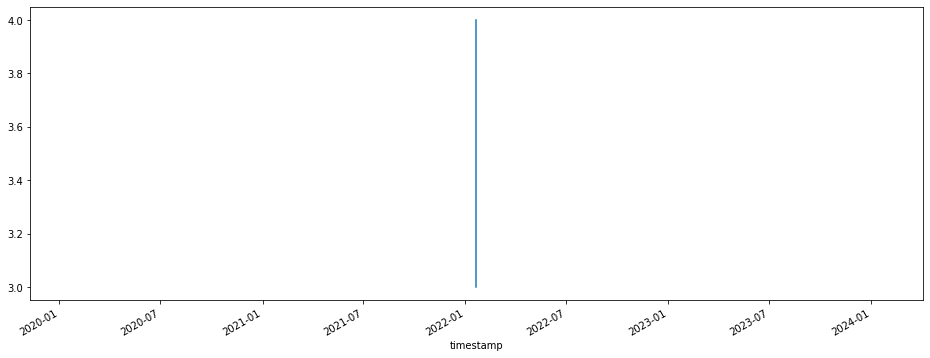

In [16]:
query_df.set_index(query_df['timestamp'])['taxi_count'].plot(figsize=(16,6))

In [60]:
hours = 24
QUERY_FULL = f"""
select x.taxi_st_id,  substr(x.taxi_st_id,5) taxi_st_num,  x.taxi_count, x.taxi_update_time, x.weather_stn_id, c.rainfall, c.weather_update_time, x.mrt_stn_id, e.mrt_final_status, e.mrt_update_time
    from (
    select a.taxi_st_id, a.taxi_count, a.taxi_update_time, b.weather_stn_id, d.mrt_stn_id
    from (
    SELECT ts_id as taxi_st_id, taxi_count, cast(timestamp_trunc(timestamp, minute) as datetime) as taxi_update_time
    FROM `taxi-compass-lewagon.api_dataset.h_taxi_stand_taxi_count`
    WHERE timestamp > TIMESTAMP_SUB(CURRENT_TIMESTAMP() , INTERVAL {hours} hour)
    ) a
left join
    (
    select weather_stn_id, taxi_st_id from `taxi-compass-lewagon.api_dataset.c_taxi_stand_weather_stn`
    ) b on a.taxi_st_id = b.taxi_st_id
left join 
    (
    select taxi_st_id, mrt_stn as mrt_stn_id from `taxi-compass-lewagon.api_dataset.c_mrt_stn_taxi_stand`
    where mrt_stn is not null
    ) d on a.taxi_st_id = d.taxi_st_id
    )x
left join 
    (
    select station_id as weather_stn_id, rainfall, datetime_trunc(datetime (update_time), minute) as weather_update_time
    from `taxi-compass-lewagon.api_dataset.h_weather_rainfall`
    where datetime(update_time) > datetime_SUB(CURRENT_DATETIME() , INTERVAL {hours} hour)
    ) c on x.weather_stn_id = c.weather_stn_id and x.taxi_update_time = c.weather_update_time
left join
    (
    select stn_id as mrt_stn_id, final_status as mrt_final_status, datetime_trunc(datetime (update_time), minute) as mrt_update_time 
    from `taxi-compass-lewagon.api_dataset.h_mrt_status_availability`
    where datetime(update_time) > datetime_SUB(CURRENT_DATETIME() , INTERVAL {hours} hour)
    ) e on x.taxi_update_time = e.mrt_update_time and x.mrt_stn_id = e.mrt_stn_id
"""
#WHERE x.taxi_st_id = 'kml_12'
#"""


query_job = bigquery_client.query(QUERY_FULL)

query_df = query_job.to_dataframe()
query_df

,taxi_st_id,taxi_st_num,taxi_count,taxi_update_time,weather_stn_id,rainfall,weather_update_time,mrt_stn_id,mrt_final_status,mrt_update_time
0,kml_4,4,0,2022-01-20 20:09:00,S118,NaN,NaT,None,NaN,NaT
1,kml_5,5,0,2022-01-20 20:09:00,S118,NaN,NaT,None,NaN,NaT
2,kml_6,6,0,2022-01-20 20:09:00,S118,NaN,NaT,None,NaN,NaT
3,kml_9,9,0,2022-01-20 20:09:00,S220,NaN,NaT,NE15,1.0,2022-01-20 20:09:00
4,kml_12,12,0,2022-01-20 20:09:00,S211,NaN,NaT,None,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...
743292,kml_345,345,8,2022-01-19 12:42:00,S123,NaN,NaT,None,NaN,NaT
743293,kml_345,345,8,2022-01-19 12:38:00,S123,NaN,NaT,None,NaN,NaT
743294,kml_345,345,8,2022-01-19 12:37:00,S123,NaN,NaT,None,NaN,NaT
743295,kml_345,345,8,2022-01-19 20:03:00,S123,NaN,NaT,None,NaN,NaT


In [61]:
df = query_df[["taxi_st_num","taxi_update_time","taxi_count","rainfall","mrt_final_status"]].copy()
df["taxi_st_num"] = df["taxi_st_num"].astype('int64')
df = df.sort_values(by=["taxi_st_num", "taxi_update_time"],ascending=True).reset_index(drop=True)
df[["rainfall"]] = df[["rainfall"]].fillna(df.groupby(['taxi_st_num'])[["rainfall"]].ffill())
df[["mrt_final_status","rainfall"]] = df[["mrt_final_status","rainfall"]].fillna(value=0)
df

,taxi_st_num,taxi_update_time,taxi_count,rainfall,mrt_final_status
0,1,2022-01-19 12:11:00,4,0.0,0.0
1,1,2022-01-19 12:12:00,5,0.0,0.0
2,1,2022-01-19 12:13:00,5,0.0,0.0
3,1,2022-01-19 12:14:00,5,0.0,0.0
4,1,2022-01-19 12:15:00,6,0.0,0.0
...,...,...,...,...,...
743292,350,2022-01-20 20:06:00,1,0.0,1.0
743293,350,2022-01-20 20:07:00,0,0.0,1.0
743294,350,2022-01-20 20:08:00,1,0.0,1.0
743295,350,2022-01-20 20:09:00,0,0.0,1.0


<AxesSubplot:xlabel='Date Time', ylabel='Taxi Count'>

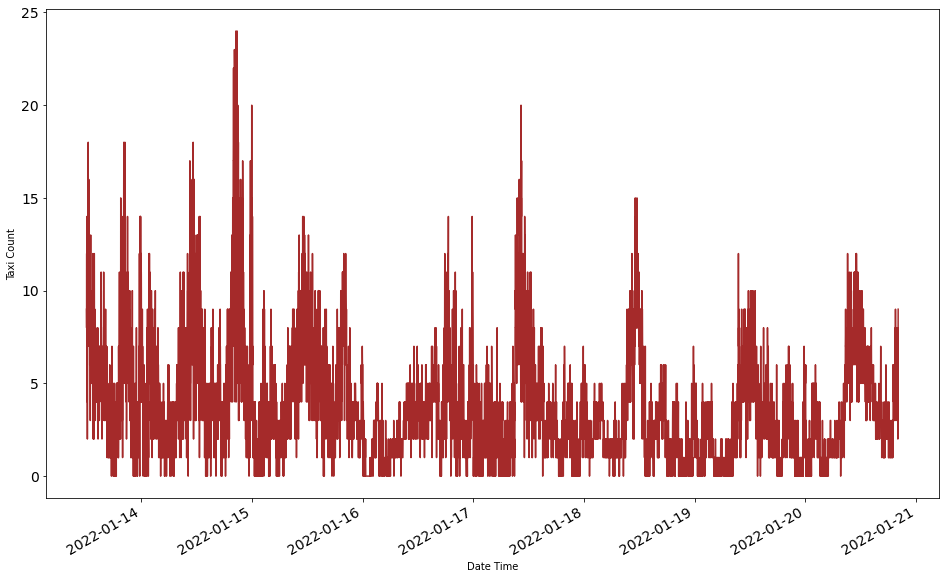

In [59]:
df[df['taxi_st_num']==1][['taxi_update_time','taxi_count']].plot(x='taxi_update_time',y='taxi_count',
                                                                 figsize=(16,10), xlabel='Date Time',
                                                                ylabel='Taxi Count',fontsize=14, legend=False, 
                                                                      color='brown')

<AxesSubplot:xlabel='Date Time', ylabel='Taxi Count'>

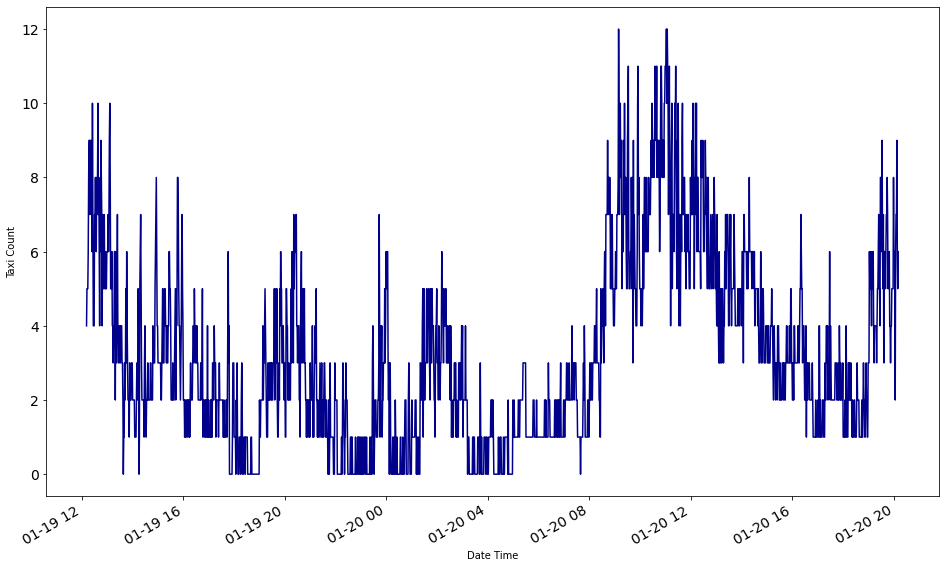

In [62]:
df[df['taxi_st_num']==1][['taxi_update_time','taxi_count']].plot(x='taxi_update_time',y='taxi_count',
                                                                 figsize=(16,10), xlabel='Date Time',
                                                                ylabel='Taxi Count',fontsize=14, legend=False, 
                                                                      color='darkblue')

## Prepare data for ML manually

In [39]:
# Keep only one taxi stand
df = df[df['taxi_st_num']==1]
df.head()

,taxi_st_num,taxi_update_time,taxi_count,rainfall,mrt_final_status
0,1,2022-01-16 01:58:00,0,0.0,0.0
1,1,2022-01-16 01:59:00,0,0.0,0.0
2,1,2022-01-16 02:00:00,0,0.0,0.0
3,1,2022-01-16 02:01:00,1,0.0,0.0
4,1,2022-01-16 02:02:00,1,0.0,0.0


In [9]:
df['weekday']=df['taxi_update_time'].apply(lambda x: x.weekday())
df.head()

/var/folders/40/h7ddhmd510jb0p4hf9b4n8fh0000gs/T/ipykernel_63100/3006510044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday']=df['taxi_update_time'].apply(lambda x: x.weekday())


,taxi_st_num,taxi_update_time,taxi_count,rainfall,mrt_final_status,weekday
0,1,2022-01-15 10:49:00,10,0.0,0.0,5
1,1,2022-01-15 10:50:00,7,0.0,0.0,5
2,1,2022-01-15 10:51:00,9,0.0,0.0,5
3,1,2022-01-15 10:52:00,5,0.0,0.0,5
4,1,2022-01-15 10:53:00,7,0.0,0.0,5


In [10]:
df['weekend']=df['weekday']>4
df.head()

/var/folders/40/h7ddhmd510jb0p4hf9b4n8fh0000gs/T/ipykernel_63100/2240160664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekend']=df['weekday']>4


,taxi_st_num,taxi_update_time,taxi_count,rainfall,mrt_final_status,weekday,weekend
0,1,2022-01-15 10:49:00,10,0.0,0.0,5,True
1,1,2022-01-15 10:50:00,7,0.0,0.0,5,True
2,1,2022-01-15 10:51:00,9,0.0,0.0,5,True
3,1,2022-01-15 10:52:00,5,0.0,0.0,5,True
4,1,2022-01-15 10:53:00,7,0.0,0.0,5,True


In [11]:
df['hour_cosine'] =np.cos(df['taxi_update_time'].apply(lambda x: x.hour)*2 * np.pi / 23)
df['hour_sine'] =np.sin(df['taxi_update_time'].apply(lambda x: x.hour)*2 * np.pi / 23)

df['minute_cosine'] =np.cos(df['taxi_update_time'].apply(lambda x: x.minute)*2 * np.pi / 59)
df['minute_sine'] =np.sin(df['taxi_update_time'].apply(lambda x: x.minute)*2 * np.pi / 59)

df.head()

/var/folders/40/h7ddhmd510jb0p4hf9b4n8fh0000gs/T/ipykernel_63100/1426575596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour_cosine'] =np.cos(df['taxi_update_time'].apply(lambda x: x.hour)*2 * np.pi / 23)
/var/folders/40/h7ddhmd510jb0p4hf9b4n8fh0000gs/T/ipykernel_63100/1426575596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour_sine'] =np.sin(df['taxi_update_time'].apply(lambda x: x.hour)*2 * np.pi / 23)
/var/folders/40/h7ddhmd510jb0p4hf9b4n8fh0000gs/T/ipykernel_63100/1426575596.py:4

,taxi_st_num,taxi_update_time,taxi_count,rainfall,mrt_final_status,weekday,weekend,hour_cosine,hour_sine,minute_cosine,minute_sine
0,1,2022-01-15 10:49:00,10,0.0,0.0,5,True,-0.917211,0.398401,0.484551,-0.874763
1,1,2022-01-15 10:50:00,7,0.0,0.0,5,True,-0.917211,0.398401,0.574787,-0.818303
2,1,2022-01-15 10:51:00,9,0.0,0.0,5,True,-0.917211,0.398401,0.658511,-0.752571
3,1,2022-01-15 10:52:00,5,0.0,0.0,5,True,-0.917211,0.398401,0.734774,-0.678312
4,1,2022-01-15 10:53:00,7,0.0,0.0,5,True,-0.917211,0.398401,0.802712,-0.596367


## Machine learning data preparation

In [12]:
X = df.drop(columns=['taxi_update_time','taxi_st_num','taxi_count'])
y = df['taxi_count']

## Machine learning Pipeline

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import set_config

set_config(display='diagram')


num_transformer = Pipeline([
    ('scaler',StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num_transf', num_transformer, ['rainfall','weekday'])],
    remainder = 'passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_transf',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['rainfall', 'weekday'])])

In [29]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

pipe = Pipeline([
    ('preprocessing',preprocessor), ('ML',RandomForestRegressor())
])

pipe.fit(X,y)
pipe.score(X,y)

0.9345536808200255

## Preprocessing full pipeline

In [76]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer

## Create features based on date time
weekday_constructor = FunctionTransformer(lambda df: pd.DataFrame(df['taxi_update_time'].
                                                                  apply(lambda x: x.weekday())))
weekend_constructor = FunctionTransformer(lambda df: pd.DataFrame(df['taxi_update_time'].
                                                                  apply(lambda x: x.weekday()>4)))
hour_cosine_constructor = FunctionTransformer(lambda df: pd.DataFrame(np.cos(df['taxi_update_time'].apply(lambda x: 
                                                                                  x.hour)*2 * np.pi / 23)))
hour_sine_constructor = FunctionTransformer(lambda df: pd.DataFrame(np.sin(df['taxi_update_time'].apply(lambda x: 
                                                                                  x.hour)*2 * np.pi / 23)))
minute_cosine_constructor = FunctionTransformer(lambda df: pd.DataFrame(np.cos(df['taxi_update_time'].apply(lambda x: 
                                                                                  x.minute)*2 * np.pi / 59)))
minute_sine_constructor = FunctionTransformer(lambda df: pd.DataFrame(np.sin(df['taxi_update_time'].apply(lambda x: 
                                                                                  x.minute)*2 * np.pi / 59)))


union_constructor = FeatureUnion([
    ('weekday',weekday_constructor),
    ('weekend',weekend_constructor),
    ('hour cosine', hour_cosine_constructor),
    ('hour sine', hour_sine_constructor),
    ('minute cosine', minute_cosine_constructor),
    ('minute sine', minute_sine_constructor),
])

union_constructor

FeatureUnion(transformer_list=[('weekday',
                                FunctionTransformer(func=<function <lambda> at 0x11ee30700>)),
                               ('weekend',
                                FunctionTransformer(func=<function <lambda> at 0x1330b1670>)),
                               ('hour cosine',
                                FunctionTransformer(func=<function <lambda> at 0x1330b1820>)),
                               ('hour sine',
                                FunctionTransformer(func=<function <lambda> at 0x1330b18b0>)),
                               ('minute cosine',
                                FunctionTransformer(func=<function <lambda> at 0x1330b14c0>)),
                               ('minute sine',
                                FunctionTransformer(func=<function <lambda> at 0x1330b1550>))])

In [79]:


num_transformer = Pipeline([
    ('scaler',StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num_transf', num_transformer, ['rainfall','taxi_st_num'])
], remainder ='drop')

union_preproc_all = FeatureUnion([
    ('rainfall scaled',preprocessor),
    ('union new features', union_constructor)
])

pipe = Pipeline([
    ('preproc data',union_preproc_all),
#     ('preprocessor',preprocessor),
    ('ML model', RandomForestRegressor())
])

pipe

Pipeline(steps=[('preproc data',
                 FeatureUnion(transformer_list=[('rainfall scaled',
                                                 ColumnTransformer(transformers=[('num_transf',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['rainfall',
                                                                                   'taxi_st_num'])])),
                                                ('union new features',
                                                 FeatureUnion(transformer_list=[('weekday',
                                                                                 FunctionTransformer(func=<function <lambda> at 0x11ee30700>)),
                                                                                ('weekend',
                                                                                 FunctionTransfo...670>)),
                                                                                ('hour '
                                                                                 'cosine',
                                                                                 FunctionTransformer(func=<function <lambda> at 0x1330b1820>)),
                                                                                ('hour '
                                                                                 'sine',
                                                                                 FunctionTransformer(func=<function <lambda> at 0x1330b18b0>)),
                                                                                ('minute '
                                                                                 'cosine',
                                                                                 FunctionTransformer(func=<function <lambda> at 0x1330b14c0>)),
                                                                                ('minute '
                                                                                 'sine',
                                                                                 FunctionTransformer(func=<function <lambda> at 0x1330b1550>))]))])),
                ('ML model', RandomForestRegressor())])

In [83]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['taxi_count'])
y = df['taxi_count']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [85]:
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

0.8125816767967724

In [110]:
y_pred = pipe.predict(X_test)
y_pred

array([1.07, 2.64, 0.99, ..., 2.06, 2.37, 6.16])

In [119]:
y_pred_rounded = np.round(y_pred).astype('int')
y_pred_rounded[:10],y_test[:10]

(array([1, 3, 1, 1, 1, 6, 0, 5, 0, 2]),
 576987     2
 780679     3
 631519     1
 1015434    1
 1139434    0
 454368     5
 1327285    0
 1259881    3
 1290117    0
 537061     2
 Name: taxi_count, dtype: int64)

In [128]:
np.shape(y_test.values),np.shape(y_pred_rounded)

((267982,), (267982,))

In [133]:
from sklearn.metrics import precision_score, accuracy_score, mean_absolute_error
accuracy = accuracy_score(y_test.values,y_pred_rounded)
mae = mean_absolute_error(y_test.values,y_pred_rounded)
print(f'accuracy is {accuracy} and mean absolute error is {mae}')

accuracy is 0.6173101178437358 and mean absolute error is 0.5538879476979797


# API aspects


## Get Lat Long in Python

In [ ]:
import geocoder
g = geocoder.ip('me')
print(g.latlng)

### Use Requests to interact with TS Finder Cloud Function in GCP

In [ ]:
import requests

r = requests.post('https://us-central1-taxi-compass-lewagon.cloudfunctions.net/tsfinder', 
                  json={"latitude":1.281260 , "longitude":103.8443})

In [ ]:
tuple(r.text.split('-'))

In [ ]:
pd.DataFrame({
        'first column': list([5,10,15])
    })